In [ ]:
!pip install keras==2.4.3

In [ ]:
!pip install tensorflow==2.4.1

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

In [10]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import (Dense, Dropout, GlobalMaxPooling2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from keras import optimizers
import tensorflow as tf
import numpy as np
import keras
import time
import random
import json


In [15]:
print("starting")

if __name__ == '__main__':
    start = time.time()
    random.seed(8675309)
    #model = VGG16()
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.2,
                                       rotation_range=5,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       # zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest')
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        "/content/archive/train/",
        target_size=(48, 48),
        subset='training',
        batch_size=64,
        class_mode='categorical'
    )
    val_gen = val_datagen.flow_from_directory(
        "/content/archive/train/",
        target_size=(48, 48),
        subset='validation',
        batch_size=64,
        class_mode='categorical'
    )
    test_gen = test_datagen.flow_from_directory(
        "/content/archive/test/",
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical'
    )

    # pre-process the data for Keras
    resnet_model = ResNet50(weights='imagenet',
                                         include_top=False,
                                         input_shape=(48, 48, 3))

    for layer in resnet_model.layers[:-4]:
        layer.trainable = False

    # I'll retrain the network from 20th layer
    # for layer in resnet_model.layers[20:]:
    #     layer.trainable = True

    layer_dict = dict([(layer.name, layer) for layer in resnet_model.layers])
    print(layer_dict)

    # Getting output tensor of the last VGG layer that we want to include
    x = layer_dict['conv5_block3_out'].output

    x = GlobalMaxPooling2D()(x)

    x = Dense(512, activation='relu')(x)

    x = Dropout(0.5)(x)

    x = Dense(7, activation='softmax')(x)

    model = Model(resnet_model.input, x)

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

    # from keras import optimizers
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=METRICS)
    model.summary()

    jsonmodel = model.to_json()
    with open('expression.json', 'w') as fp:
        json.dump(jsonmodel, fp)

    epochs = 50
    batch_size = 64

    lrd = ReduceLROnPlateau(monitor='val_loss', patience=10,
                            verbose=1, factor=0.50, min_lr=1e-10)

    es = EarlyStopping(verbose=1, patience=10)

    checkpointer = ModelCheckpoint(filepath='expression.hdf5',
                                   verbose=1)

    history = model.fit_generator(train_gen, epochs=epochs, callbacks=[lrd, checkpointer, es],
                                  verbose=1, validation_data=val_gen, validation_steps=5741//batch_size,
                                  steps_per_epoch=22968//batch_size)

    print(history.history.keys())
    
    end = time.time()
    print(end - start)


starting
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
{'input_7': <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1b9cc43b90>, 'conv1_pad': <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f1abc72ce90>, 'conv1_conv': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1abc853b10>, 'conv1_bn': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1abc85d350>, 'conv1_relu': <tensorflow.python.keras.layers.core.Activation object at 0x7f1abc757490>, 'pool1_pad': <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f1abc75fa10>, 'pool1_pool': <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1abc73ec90>, 'conv2_block1_1_conv': <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1abc9cee50>, 'conv2_block1_1_bn': <tensorflow.python.keras.layers.normalization_v2.BatchNormaliz

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
358/358 [==============================] - 55s 139ms/step - loss: 2.1526 - accuracy: 0.8413 - precision: 0.1978 - recall: 0.0360 - auc: 0.6064 - val_loss: 1.8024 - val_accuracy: 0.8571 - val_precision: 0.5000 - val_recall: 1.7556e-04 - val_auc: 0.6582

Epoch 00001: saving model to expression.hdf5
Epoch 2/50
358/358 [==============================] - 43s 120ms/step - loss: 1.8202 - accuracy: 0.8570 - precision: 0.2521 - recall: 6.1145e-04 - auc: 0.6479 - val_loss: 1.7942 - val_accuracy: 0.8571 - val_precision: 0.5000 - val_recall: 1.7556e-04 - val_auc: 0.6697

Epoch 00002: saving model to expression.hdf5
Epoch 3/50
358/358 [==============================] - 44s 123ms/step - loss: 1.8071 - accuracy: 0.8569 - precision: 0.2605 - recall: 7.7279e-04 - auc: 0.6544 - val_loss: 1.7734 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 1.7556e-04 - val_auc: 0.6787

Epoch 00003: saving model to expression.hdf5
Epoch 4/50
358/358 [==============================] - 43s 119ms/s

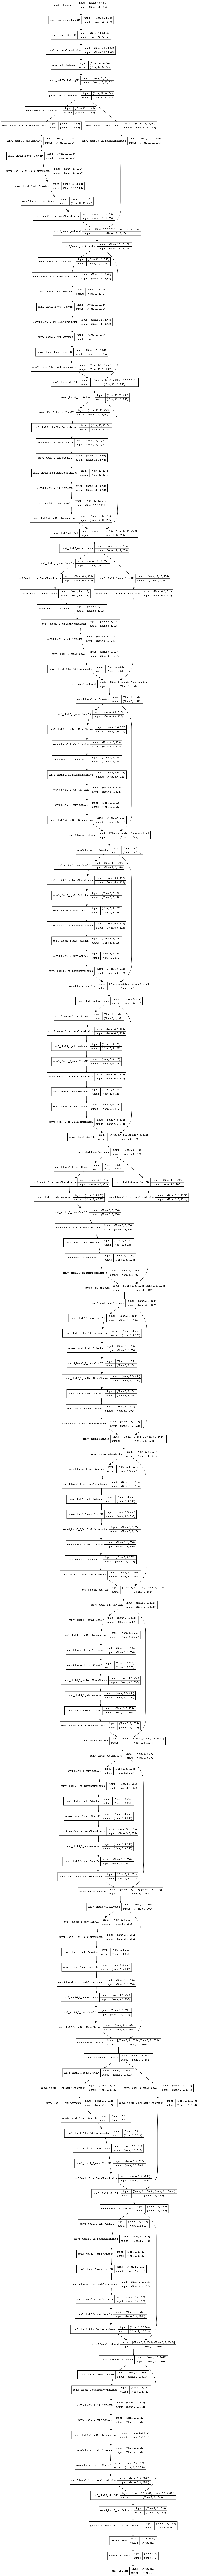

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

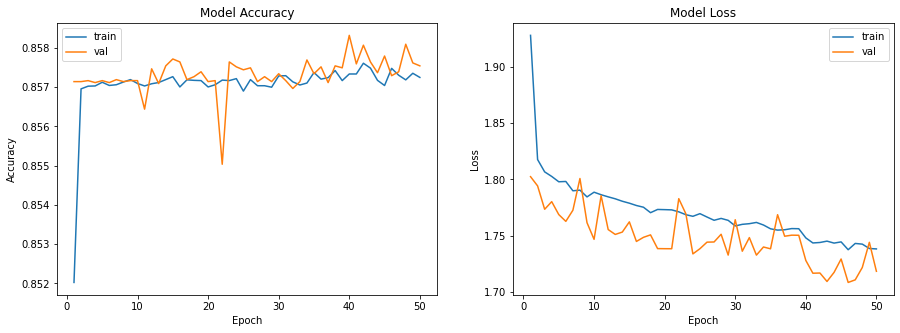

In [17]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

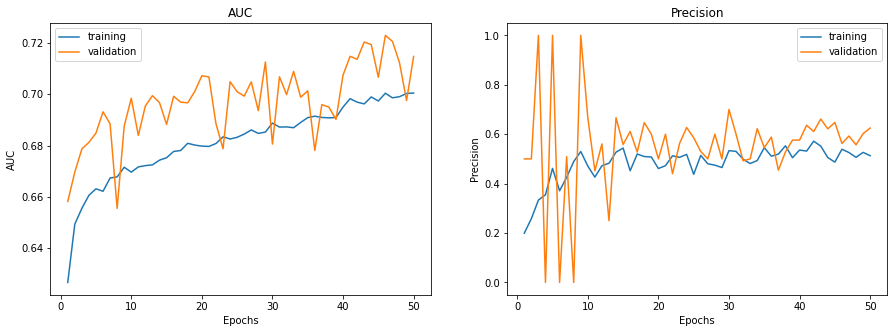

In [18]:
auc = history.history['auc']
val_auc = history.history['val_auc']
precision = history.history['precision']
val_precision = history.history['val_precision']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(range(1, len(auc) + 1), auc)
ax1.plot(range(1, len(val_auc) + 1), val_auc)
ax1.set_title('AUC')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('AUC')
ax1.legend(['training', 'validation'])

ax2.plot(range(1, len(precision) + 1), precision)
ax2.plot(range(1, len(val_precision) + 1), val_precision)
ax2.set_title('Precision')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend(['training', 'validation'])

In [19]:
expression_dict = list(train_gen.class_indices.keys())
expression_dict

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

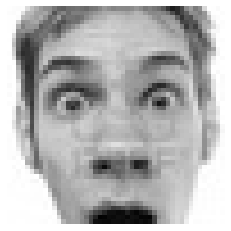

surprise
[[0.0682963  0.00394444 0.21328603 0.11612193 0.07078253 0.05325619
  0.47431257]]


In [20]:
from keras.preprocessing import image

def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(48,48))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


# loaded_model = load_model("model_vgg16.h5")

img_path = '/content/archive/test/surprise/PublicTest_53542593.jpg'

new_image = load_image(img_path)

pred = model.predict(new_image)

predictions = list(pred[0])
expression_output = expression_dict[(predictions.index(max(predictions)))]

print(expression_output)
print(pred)